In [211]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

TRUE_VALUES = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 0]

class WalkState(Enum):
    Zero = 0
    A = 1
    B = 2
    C = 3
    D = 4
    E = 5
    Goal = 6

def get_reward(state: WalkState):
    rewards = {
        WalkState.Goal: 1,
    }
    return rewards.get(state, 0)

def pick_action():
    actions = ['left', 'right']
    return actions[np.random.binomial(1, 0.5)]
    # return np.random.choice(['left', 'right'], p=[0.5, 0.5])

def get_init_values(val:int=0.5):
    values = [0]
    values = values + [val for i in range (len(WalkState)-2)] # 7 States, 2 final: 0 and -1
    values.append(0)
    return values

def plot_state_values(state_values, label, color='k'):
    states = [WalkState(i+1).name for i in range(len(state_values))]
    plt.plot(states, state_values, color=color, linestyle='solid', marker='o', label=f'{label}')

# lambda function for discrete color list from red to green, leght of log_episodes
get_colors = lambda n: plt.cm.viridis(np.linspace(0, 1, n))

class RandomWalk:
    def __init__(self, init_state_=WalkState.C.value) -> None:
        self.init_state = WalkState(init_state_)

        self.state = WalkState(init_state_)
    
    def __repr__(self) -> str:
        return f'RandomWalk(current state: {self.state.name})'
    
    # Actions
    def excecute_action(self, action):
        if action == 'left':
            self.left()
        elif action == 'right':
            self.right()

    
    def left(self):
        if self.state == WalkState.Zero:
            raise Exception('Cannot move left from the zero state')
        self.state = WalkState(self.state.value - 1)

    def right(self):
        if self.state == WalkState.Goal:
            raise Exception('Cannot move right from the goal state')
        self.state = WalkState(self.state.value + 1)


In [170]:
def montecarlo_estimation(trajectory:list, rewards:list, values:list, alpha=0.1, gamma=1.0):
    """
    Estimates the state values using the montecarlo method
    trajectory: list of trajectories in episode
    rewards: list of rewards in episode
    values: list of state values
    alpha: learning rate
    """
    Gt = 0
    for St, Rtp1 in zip(reversed(trajectory[:-1]), reversed(rewards)):
        Gt = gamma*Gt + Rtp1
        values[St] += alpha*(Gt - values[St])
    
    return values

In [171]:
def estimate_values(method, init_values:list, n_episodes=100, alpha=0.1, gamma=1.0):
    """
    Estimates the state values using one of the methods: montecarlo or temporal difference
    """
    results = {
        'method': method,
        'alpha': alpha,
        'state_values': [],
        'rmse': [],
    }
    state_values = init_values
    
    for episode in range(n_episodes):
        sm = RandomWalk()
        episode_rewards = [0]
        trajectory = [sm.state.value]

        # episode starts
        while True:
            action = pick_action()
            Stm1 = sm.state
            sm.excecute_action(action)

            trajectory.append(sm.state.value)
            Rt = get_reward(sm.state)

            if method == 'td':
                state_values[Stm1.value] += alpha*(Rt + gamma*state_values[sm.state.value] - state_values[Stm1.value])

            episode_rewards.append(Rt)

            if sm.state in (WalkState.Goal, WalkState.Zero):
                    # end of episode
                    break
        # /episode
            
        # Montecarlo estimation
        if method == 'mc':
            state_values = montecarlo_estimation(
                trajectory=trajectory, rewards=episode_rewards,values=state_values,
                alpha=alpha, gamma=gamma
            )
        
        results['state_values'] = state_values

        # log RMSE
        rmse_ep = np.sqrt(np.mean((np.array(TRUE_VALUES[1:-1]) - np.array(state_values[1:-1]))**2))
        results['rmse'].append(rmse_ep)

    return state_values, results

In [221]:
all_results = {'mc':{}, 'td':{}} 
# plot_state_values(state_values=get_init_values()[1:-1], label='init values', color='r')
# plot_state_values(state_values=true_values[1:-1], label='true values', color='g')


n_episodes = 100
gamma =1.0

# Run the estimation
ALPHAS_MC = [0.01,0.03,0.1,0.3]
# ALPHAS_MC = [0.01]
ALPHAS_TD = [0.05,0.1,0.15]
# ALPHAS_TD = [0.05]
ALPHAS = {'mc': ALPHAS_MC, 'td': ALPHAS_TD}

for method in ['mc', 'td']:
    for alpha in ALPHAS[method]:
        init_values = get_init_values()
        state_values, results = estimate_values(method, init_values, n_episodes, alpha, gamma)
        all_results[method][results['alpha']] = results['rmse']


In [222]:
for method, results in all_results.items():
    for alpha, rmse in results.items():
        print(f'method: {method}| alpha: {alpha}, RMSE={rmse[-1]}')

method: mc| alpha: 0.01, RMSE=0.10756335195597266
method: mc| alpha: 0.03, RMSE=0.05777925461840829
method: mc| alpha: 0.1, RMSE=0.08125264173507415
method: mc| alpha: 0.3, RMSE=0.14556533685829254
method: td| alpha: 0.05, RMSE=0.044282189930246074
method: td| alpha: 0.1, RMSE=0.04320380665536249
method: td| alpha: 0.15, RMSE=0.03697430163737152


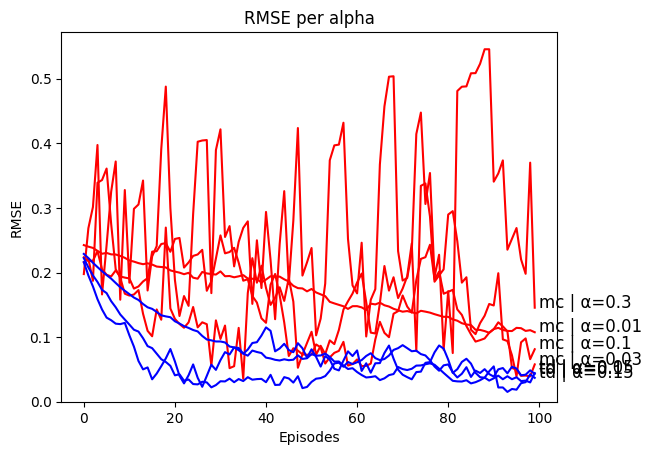

In [224]:
# plot RMSE per alpha
method_colors = {'mc':'r', 'td':'b'}
plt.figure()
for method, results in all_results.items():
    for alpha, rmse in results.items():
        # if method == 'mc':
        #     continue
        plt.plot(rmse, color=method_colors[method])
        # plt.plot(rmse)
        label = f"{method} | α={alpha}"
        plt.text(len(rmse), rmse[len(rmse)-1], label, fontsize=12, color='k')
        
plt.xlabel('Episodes')
plt.ylabel('RMSE')
plt.ylim(0)
plt.title('RMSE per alpha')
# plt.legend()
plt.show()